In [5]:
!pip install pandas
!pip install yfinance
!pip install scikit-learn
!pip install projectpro
!pip install keras-tuner

In [6]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

import yfinance as yf

import keras
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import os 

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.layers import LSTM, SimpleRNN, Dense
from keras.models import Sequential
from keras.layers import Dense

from projectpro import model_snapshot, checkpoint
import pandas_ta as ta

import keras_tuner as kt

In [7]:
keras.backend.set_image_data_format("channels_last")
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
yf.pdr_override()
%matplotlib inline

In [8]:
now = datetime(year=2024, month=2, day=23)
start = now - relativedelta(years=10)
dataset = yf.download('NVDA', start, now)
print(dataset)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-02-24    4.650000    4.762500    4.607500    4.727500    4.460092   
2014-02-25    4.700000    4.720000    4.635000    4.685000    4.439953   
2014-02-26    4.675000    4.745000    4.662500    4.677500    4.432847   
2014-02-27    4.677500    4.725000    4.612500    4.625000    4.383092   
2014-02-28    4.600000    4.645000    4.527500    4.595000    4.354661   
...                ...         ...         ...         ...         ...   
2024-02-15  738.690002  739.750000  724.000000  726.580017  726.580017   
2024-02-16  741.000000  744.020020  725.010010  726.130005  726.130005   
2024-02-20  719.469971  719.559998  677.340027  694.520020  694.520020   
2024-02-21  680.059998  688.880005  662.479980  674.719971  674.719971   
2024-02-22  750.250000  785.750000  742.200

In [9]:
def train_test_split(dataset, end, columns=['Close']):
    start_test = end - relativedelta(years=1)
    end_test = end

    end_train = start_test
    start_train = end_train - relativedelta(years=4)

    train = dataset.loc[start_train:end_train, columns].values
    test = dataset.loc[start_test:end_test, columns].values
    
    return train, test

In [10]:
mv_features = 6

In [11]:
multi_variate_df = yf.download('NVDA', start, now)

[*********************100%***********************]  1 of 1 completed


In [12]:
multi_variate_df['RSI'] = ta.rsi(multi_variate_df.Close, length=15)
multi_variate_df['EMAF'] = ta.ema(multi_variate_df.Close, length=20)
multi_variate_df['EMAM'] = ta.ema(multi_variate_df.Close, length=100)
multi_variate_df['EMAS'] = ta.ema(multi_variate_df.Close, length=150)

In [13]:
multi_variate_df['Target'] = multi_variate_df['Adj Close'] - dataset.Open
multi_variate_df['Target'] = multi_variate_df['Target'].shift(-1)
multi_variate_df.dropna(inplace=True)
multi_variate_df.drop(['Volume', 'Close'], axis=1, inplace=True)

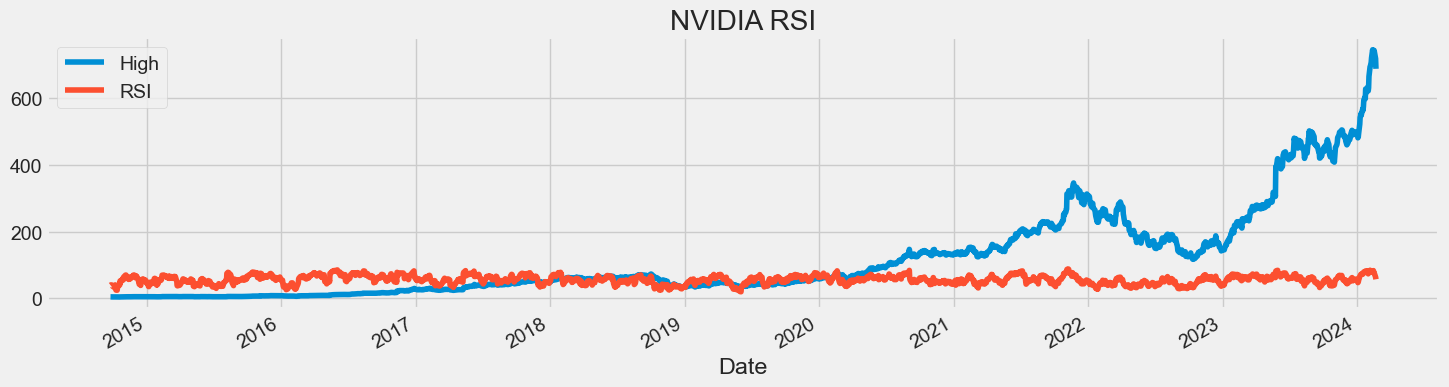

In [14]:
multi_variate_df.loc[f"{start}":f"{now}", ['High', 'RSI']].plot(figsize=(16, 4), legend=True)
plt.title("NVIDIA RSI")
plt.show()

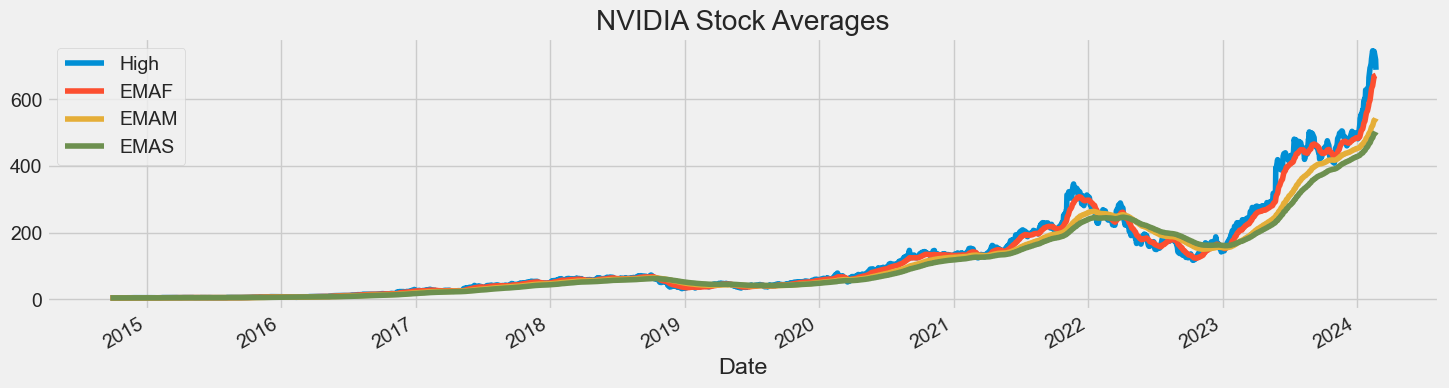

In [15]:
multi_variate_df.loc[f"{start}":f"{now}", ['High', 'EMAF', 'EMAM', 'EMAS']].plot(figsize=(16, 4), legend=True)
plt.title("NVIDIA Stock Averages")
plt.show()

In [16]:
feat_columns = ['Open', 'High', 'RSI', 'EMAF', 'EMAM', 'EMAS']
label_col = ['Target']

In [17]:
mv_training_set, mv_test_set = train_test_split(multi_variate_df, now, feat_columns + label_col)

In [18]:
X_train = mv_training_set[:, :-1]
y_train = mv_training_set[:, -1]

X_test = mv_test_set[:, :-1]
y_test = mv_test_set[:, -1]

In [19]:
mv_sc = MinMaxScaler(feature_range=(0, 1))
X_train = mv_sc.fit_transform(X_train).reshape(-1, 1, mv_features)
X_test = mv_sc.transform(X_test).reshape(-1, 1, mv_features)

In [20]:
model_mv = Sequential()
model_mv.add(LSTM(units=125, input_shape=(1, mv_features)))
model_mv.add(Dense(units=1))
# Compiling the model
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
model_mv.compile(optimizer=optimizer, loss="mse")
# model_mv.compile(optimizer="RMSprop", loss="mse")

In [21]:
def plot_loss(history):
    plt.figure(figsize=(15,10))
    
    # Adjusting line color to green and making it thinner using 'linewidth'
    plt.plot(history.history['loss'], label='loss', color='green', linewidth=2)
    
    # Enhancing plot appearance
    plt.legend(loc='best')
    plt.title('Model Loss Over Epochs')  # Adding a title for clarity
    plt.xlabel('Epochs')  # Labeling the x-axis
    plt.ylabel('Loss')  # Labeling the y-axis
    plt.grid(True)  # Adding a grid for better readability
    plt.tight_layout()  # Adjusting subplots to fit into the figure area
    
    plt.show()

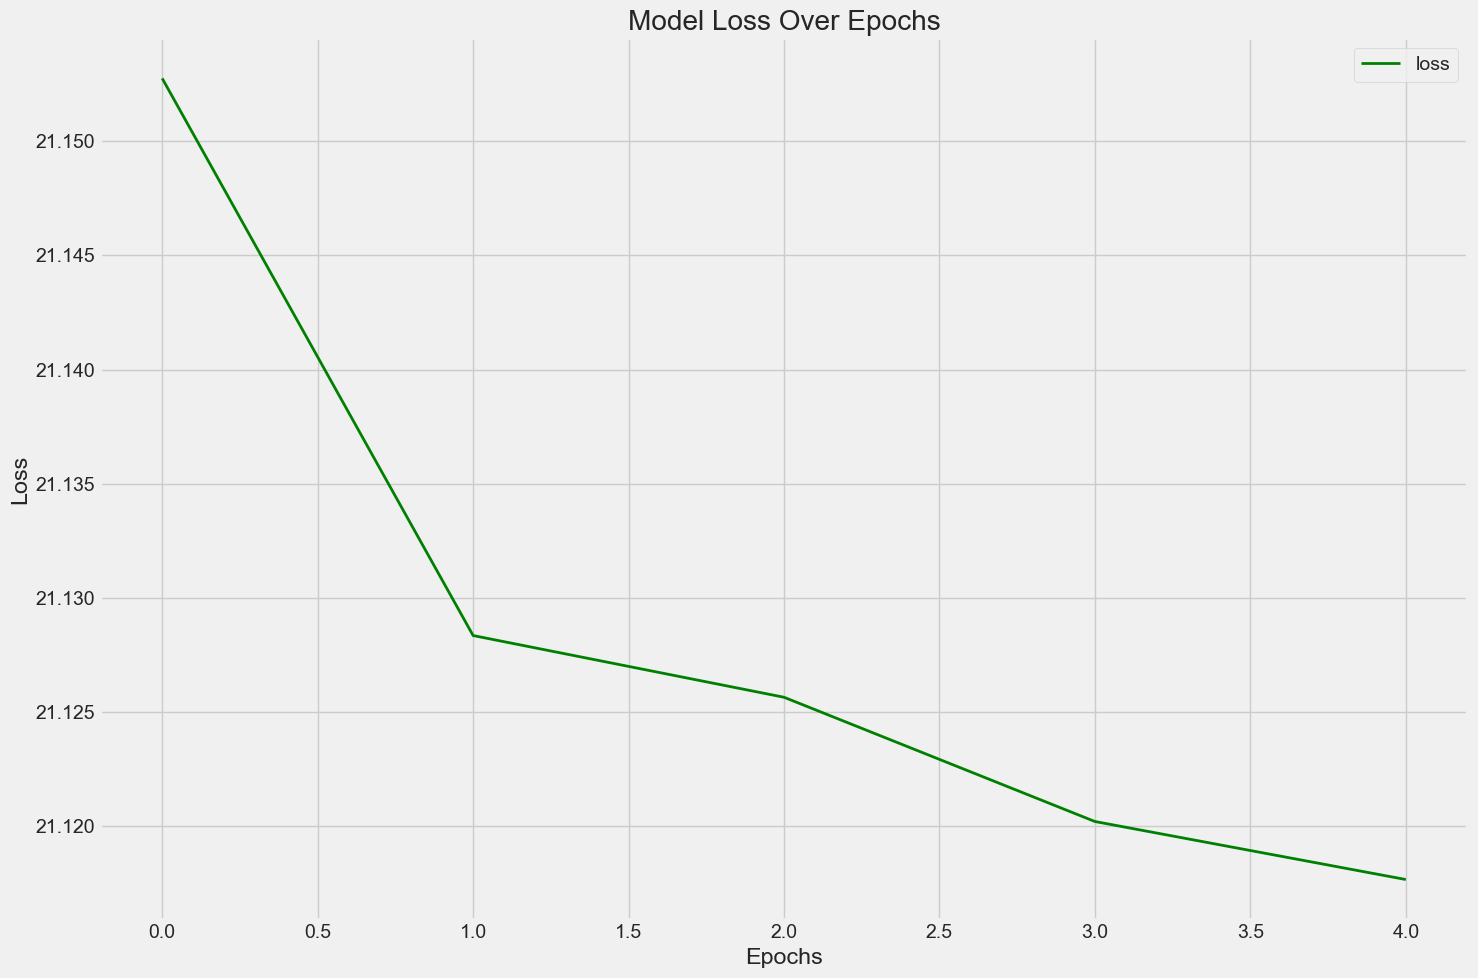

In [22]:
history = model_mv.fit(X_train, y_train, epochs=5, batch_size=64, verbose=0)
model_snapshot("34db30")
plot_loss(history)

8/8 [==============================] - 0s 1ms/step


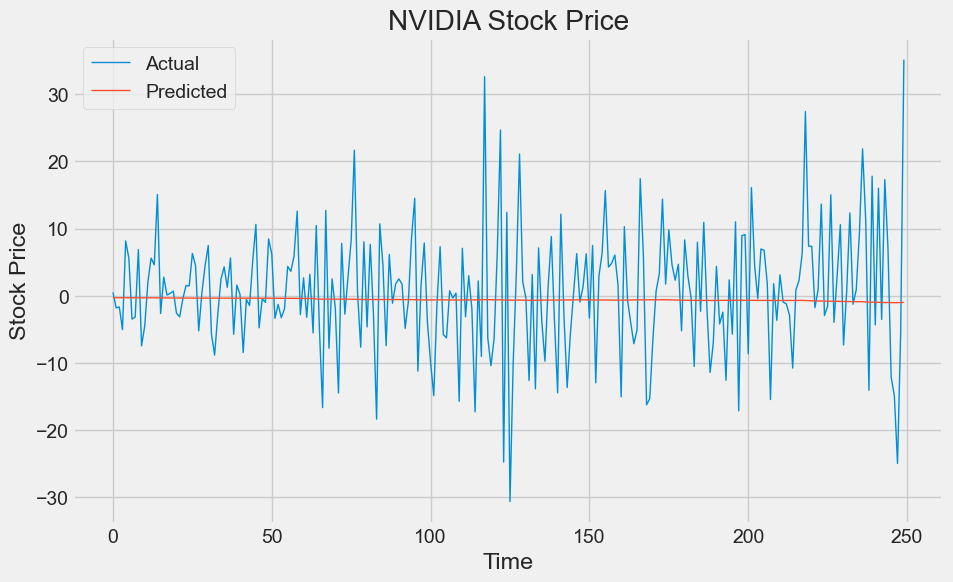

In [23]:
predictions = model_mv.predict(X_test)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', linewidth=1)  # Adjust linewidth here
plt.plot(predictions, label='Predicted', linewidth=1)  # Adjust linewidth here
plt.title("NVIDIA Stock Price")
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from keras_tuner import RandomSearch

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), input_shape=(1, mv_features)))
    model.add(Dense(units=1))
    model.compile(optimizer=keras.optimizers.RMSprop(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss="mse")
    return model


In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Set the number of models to try
    executions_per_trial=1,
    directory='nvidia_model_tuning',
    project_name='lstm_stock_prediction'
)


In [ ]:
tuner.search(X_train, y_train, epochs=10, validation_split=0.2, batch_size=64)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


In [ ]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)
